In [1]:
import numpy as np
from sympy import symbols, Matrix
from scipy.integrate import solve_ivp
import scipy.linalg as la
import matplotlib.pylab as plt

In [39]:
tspan = np.linspace(0, 100, 100)

def sortEig(A):
    l, v = la.eig(A)
    idx = np.argsort(np.abs(l))
    l_sorted = l[idx]
    v_sorted = v[:, idx]
    return l_sorted, v_sorted

def ode_system(t, y, R12, R14, R23, R25, R36, R45, R56, KA, KR, gamma3, gamma4, gamma5, delta, damp1 = 1, damp2 = 1, damp3 = 1, damp4 = 1, damp5 = 1, damp6 = 1):
    n1, n2, n3, n4, n5, P = y * [damp1, damp2, damp3, damp4, damp5, damp6]
    sum_n345 = n3 + n4 + n5
    CC_A = 1 - sum_n345 / KA
    CC_R = 1 - sum_n345 / KR
    dn1dt = - (R12 + R14)*n1
    dn2dt = R12*n1 - (R23 + R25)*n2
    dn3dt = R23*n2 - R36*n3 + gamma3*n3*CC_A - delta*n3
    dn4dt = R14*n1 - R45*n4 + gamma4*n4*CC_R - delta*n4
    dn5dt = R25*n2 + R45*n4 - R56*n5 + gamma5*n5*CC_R - delta*n5
    dPdt = (R56*n5 + R36*n3)*(1-P)
    return [dn1dt, dn2dt, dn3dt, dn4dt, dn5dt, dPdt]

def ode_system_linear(t, y, R12, R14, R23, R25, R36, R45, R56, KA, KR, gamma3, gamma4, gamma5, delta, damp1 = 1, damp2 = 1, damp3 = 1, damp4 = 1, damp5 = 1, damp6 = 1):
    n1, n2, n3, n4, n5, P = y * [damp1, damp2, damp3, damp4, damp5, damp6]
    dn1dt = - (R12 + R14)*n1
    dn2dt = R12*n1 - (R23 + R25)*n2
    dn3dt = R23*n2 - R36*n3 + gamma3*n3 - delta*n3
    dn4dt = R14*n1 - R45*n4 + gamma4*n4 - delta*n4
    dn5dt = R25*n2 + R45*n4 - R56*n5 + gamma5*n5 - delta*n5
    dPdt = (R56*n5 + R36*n3)
    return [dn1dt, dn2dt, dn3dt, dn4dt, dn5dt, dPdt]

# Our Best
N_crypts = 1e+7
r1 = 156
u = 10e-7 * r1
mu = 10e-9 * r1
gamma3 = 0.2
gamma4 = 0.07
gamma5 = 0.07
delta = 0.05
KA = 562
KR = 1780

values = {
    "r1": 156,
    "u": 10e-7 * r1,
    "mu": 10e-9 * r1,
    "R12": 2 * u,
    "R14": mu,
    "R23": u,
    "R25": mu,
    "R36": mu,
    "R45": 2 * u,
    "R56": u,
    "N_crypts": N_crypts,
    "K_A": KA,
    "K_R": KR,
    "gamma_3": gamma3,
    "gamma_4": gamma4,
    "gamma_5": gamma5,
    "delta": delta,
}

def reset_parameters(values_dict):
    global R12, R14, R23, R25, R36, R45, R56, N_crypts, K_A, K_R, gamma_3, gamma_4, gamma_5, delta, u, mu
    r1 = values_dict["r1"]
    u = values_dict["u"]
    mu = values_dict["mu"] 
    R12 = values_dict["R12"]
    R14 = values_dict["R14"]
    R23 = values_dict["R23"]
    R25 = values_dict["R25"]
    R36 = values_dict["R36"]
    R45 = values_dict["R45"]
    R56 = values_dict["R56"]
    N_crypts = values_dict["N_crypts"]
    K_A = values_dict["K_A"]
    K_R = values_dict["K_R"]
    gamma_3 = values_dict["gamma_3"]
    gamma_4 = values_dict["gamma_4"]
    gamma_5 = values_dict["gamma_5"]
    delta = values_dict["delta"]

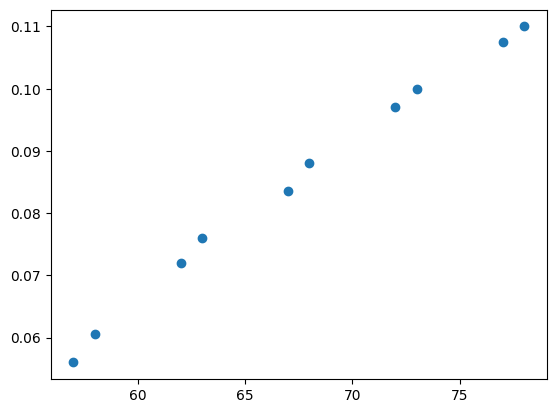

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Data for Gm and Gf
Gm = [
    [57, 16.8, 6.7, 0.6],
    [62, 18.1, 8.3, 1.0],
    [67, 19.2, 9.3, 1.3],
    [72, 19.9, 10.1, 2.0],
    [77, 19.1, 10.5, 2.6],
    [58, 17.9, 7.1, 0.7],
    [63, 19.1, 8.7, 1.1],
    [68, 20.1, 9.7, 1.5],
    [73, 20.6, 10.3, 2.1],
    [78, 19.6, 10.6, 2.7]
]

Gf = [
    [57, 10.1, 3.6, 0.3],
    [62, 11.4, 4.6, 0.5],
    [67, 12.6, 5.4, 0.7],
    [72, 13.7, 6.2, 1.1],
    [77, 13.5, 6.8, 1.6],
    [58, 10.9, 3.9, 0.4],
    [63, 12.2, 4.9, 0.5],
    [68, 13.4, 5.6, 0.8],
    [73, 14.3, 6.4, 1.2],
    [78, 13.9, 7.0, 1.7]
]

# Calculate incidence per age
Gm_data = [[row[0], (row[2] + row[3]) / 100] for row in Gm]
Gf_data = [[row[0], (row[2] + row[3]) / 100] for row in Gf]

# Sort both data sets
Gm_data_sort = sorted(Gm_data, key=lambda x: x[0])
GF_data_sort = sorted(Gf_data, key=lambda x: x[0])

# Average and sort
data = [[x[0], (x[1] + y[1]) / 2] for x, y in zip(Gm_data_sort, GF_data_sort)]
data_sorted = sorted(data, key=lambda x: x[0])

# Extract x and y values for plotting
x_dat = [row[0] for row in data_sorted]
y_dat = [row[1] for row in data_sorted]
plt.scatter(x_dat,y_dat)

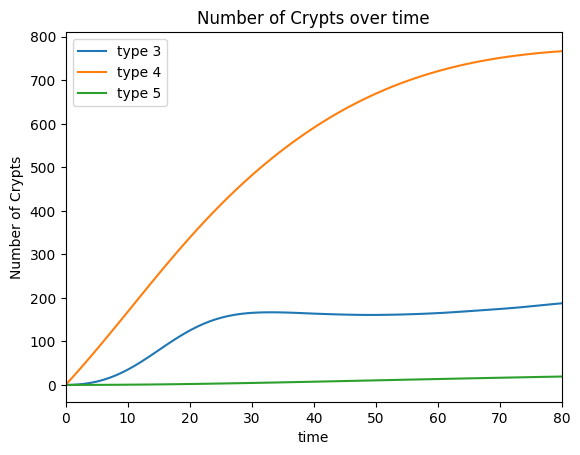

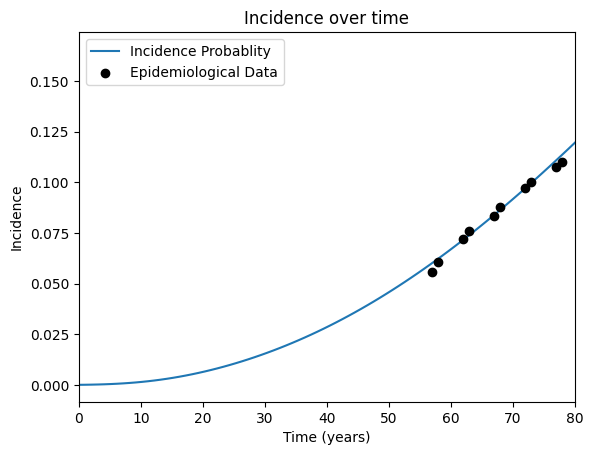

In [41]:
sol = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

# plt.plot(sol.t, sol.y[0,:], label='1') # this is too big to plot
# plt.plot(sol.t, sol.y[1,:], label="type 2") # linear growth
plt.plot(sol.t, sol.y[2,:], label="type 3")
plt.plot(sol.t, sol.y[3,:], label="type 4")
plt.plot(sol.t, sol.y[4,:], label="type 5")
# plt.plot(sol.t, sol.y[5,:], label='incidence probablity')
plt.xlim(0,80)
plt.xlabel('time')
plt.ylabel('Number of Crypts')
plt.legend(loc='upper left')
plt.title("Number of Crypts over time")
#plt.savefig('figures/Simulation.png')
plt.show()

plt.plot(sol.t-4.97, sol.y[5,:]*(1-delta/1.01199), zorder=1, label='Incidence Probablity')
plt.scatter(x_dat,y_dat,color='k', zorder=2, label='Epidemiological Data')
plt.xlim(0,80)
plt.xlabel('Time (years)')
plt.ylabel('Incidence')
plt.legend(loc='upper left')
plt.title("Incidence over time")
#plt.savefig('figures/SimulationIncidenceProbabililty.png')
plt.show()

Best Parameter Sets:
1. SSE: 0.0000, R: 156.00, KA: 5.62e+02, KR: 1.78e+03
2. SSE: 0.0001, R: 168.00, KA: 1.78e+01, KR: 1.33e+03
3. SSE: 0.0001, R: 168.00, KA: 1.33e+01, KR: 1.33e+03
4. SSE: 0.0001, R: 168.00, KA: 1.00e+01, KR: 1.33e+03
5. SSE: 0.0001, R: 168.00, KA: 2.37e+01, KR: 1.33e+03
6. SSE: 0.0001, R: 168.00, KA: 3.16e+01, KR: 1.33e+03
7. SSE: 0.0001, R: 168.00, KA: 4.22e+01, KR: 1.33e+03
8. SSE: 0.0001, R: 168.00, KA: 5.62e+01, KR: 1.33e+03
9. SSE: 0.0001, R: 168.00, KA: 7.50e+01, KR: 1.33e+03
10. SSE: 0.0001, R: 174.00, KA: 4.22e+02, KR: 1.00e+03


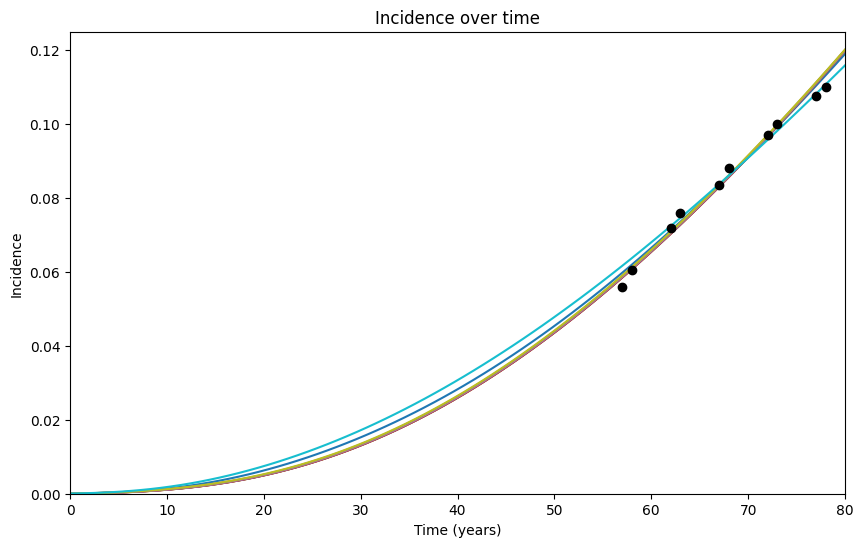

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters
N_crypts = 1e+7
rmin = 150
rmax = 270
rsteps = 20
r_array = np.linspace(rmin, rmax, rsteps + 1)  # R values

gamma3 = 0.2
gamma4 = 0.07
gamma5 = 0.07
delta = 0.05
kmin = 1
kmax = 3.5
ksteps = 20
ka_array = np.logspace(kmin, kmax, ksteps + 1)  # KA values (logarithmic scale)
kr_array = np.logspace(kmin, kmax, ksteps + 1)  # KR values (logarithmic scale)

# Error tracking
errors = []


# Iterate through parameters
for r_1 in r_array:
    u = 10e-7 * r_1
    mu = 10e-9 * r_1

    for ka in ka_array:
        for kr in kr_array:
            # Solve ODE system
            sol = solve_ivp(
                ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
                args=(2*u, mu, u, mu, mu, 2*u, u, ka, kr, gamma3, gamma4, gamma5, delta)
            )
            
            # Adjust x_dat to match the time step (shift by 4.79)
            t_search = np.array(x_dat) + 4.79
            
            # Match data to model
            model_values = np.interp(t_search, sol.t, sol.y[5, :]) * (1 - delta / 1.01199)
            
            # Calculate SSE
            sse = np.sum((model_values - y_dat)**2)
            
            # Store parameters and error
            errors.append((sse, r_1, ka, kr))

# Sort errors by SSE
errors = sorted(errors, key=lambda x: x[0])

# Get the best parameter sets
best_params = errors[:10]


print("Best Parameter Sets:")
for rank, (sse, r_1, ka, kr) in enumerate(best_params, start=1):
    print(f"{rank}. SSE: {sse:.4f}, R: {r_1:.2f}, KA: {ka:.2e}, KR: {kr:.2e}")

# Plot the best models
plt.figure(figsize=(10, 6))
for _, r_1, ka, kr in best_params:
    u = 10e-7 * r_1
    mu = 10e-9 * r_1
    
    sol = solve_ivp(
        ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
        args=(2*u, mu, u, mu, mu, 2*u, u, ka, kr, gamma3, gamma4, gamma5, delta)
    )

    # Get model values for plotting
    model_values = sol.y[5, :] * (1 - delta / 1.01199)
    plt.plot(sol.t - 4.79, model_values, zorder=1) #label=f"R={r_1:.2f}, KA={ka:.2e}, KR={kr:.2e}")

# Plot observed data
plt.scatter(x_dat, y_dat, color='black', zorder=2, label="Observed Data")

# Add labels, legend, and title
plt.xlabel('Time (years)')
plt.ylabel('Incidence')
plt.xlim(0, 80)
plt.ylim(0,0.125)
plt.title("Incidence over time")
#plt.legend(loc='upper left')
plt.show()


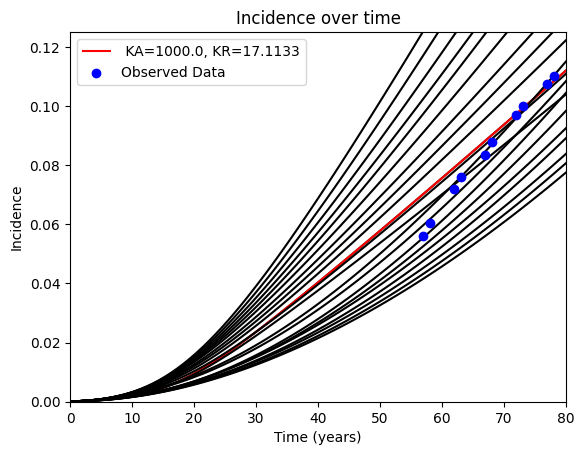

In [45]:
#Paper Test Values

K_vals = np.array([
    [1646.9, 1258.93],
    [1467.8, 1122.02],
    [1359.36, 926.119],
    [1258.93, 794.328],
    [1122.02, 764.422],
    [1079.78, 607.202],
    [1122.02, 354.813],
    [1079.78, 261.016],
    [1039.12, 171.133],
    [1000., 17.1133],
    [926.119, 107.978],
    [891.251, 26.1016],
    [207.332, 501.187],
    [171.133, 446.684],
    [10., 413.682],
    [23.2631, 368.695],
    [65.5642, 328.599],
    [10., 304.322],
    [31.6228, 271.227],
    [10., 251.189],
    [10., 232.631]
])

r1 = 204 #Keeping r1 constant (as best value)
u = 10e-7 * r1
mu = 10e-9 * r1
K_a = K_vals[:,0]
K_r = K_vals[:,1]

for x,y in zip(K_a,K_r):
    sol = solve_ivp(
    ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, x, y, gamma3, gamma4, gamma5, delta)
    )
    model_values = sol.y[5, :] * (1 - delta / 1.01199)
    plt.plot(sol.t - 4.79, model_values, color='k', zorder=1) #label=f"R={r_1:.2f}, KA={ka:.2e}, KR={kr:.2e}")
    if x==1000:
        plt.plot(sol.t - 4.79, model_values, color='red', zorder=1, label=f" KA={x}, KR={y}")

# Plot observed data
plt.scatter(x_dat, y_dat, color='blue', zorder=2, label="Observed Data")

plt.xlabel('Time (years)')
plt.ylabel('Incidence')
plt.xlim(0, 80)
plt.ylim(0,0.125)
plt.title("Incidence over time")
plt.legend(loc='upper left')
plt.show()




Case 1: SSE = 1654607.8037830184
Case 2: SSE = 1654292.0176921743
Case 3: SSE = 170330.08274325018
Case 4: SSE = 2041377.4274414983
Case 5: SSE = 2041140.858589437
Case 6: SSE = 2041760.8509886507
Max SSE occurs at case 6, with value: 2041760.8509886507


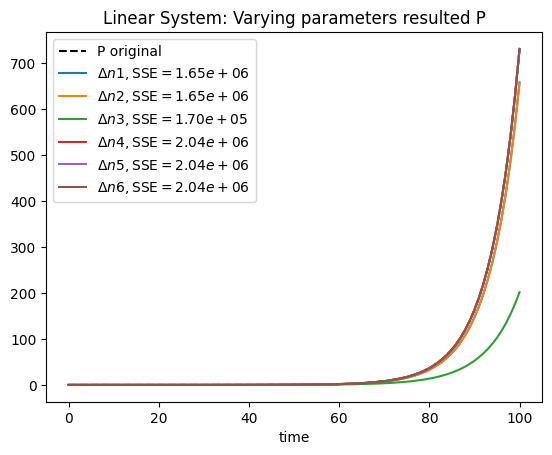

In [46]:
# simulated variation in linear ode system
reset_parameters(values)
print()
sol_0 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 1, 1, 1, 1, 1))
sol_1 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 0.9, 1, 1, 1, 1, 1))
sol_2 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 0.9, 1, 1, 1, 1))
sol_3 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 1, 0.9, 1, 1, 1))
sol_4 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 1, 1, 0.9, 1, 1))
sol_5 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 1, 1, 1, 0.9, 1))
sol_6 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 1, 1, 1, 1, 0.9))

# Compute SSE (Sum of Squared Errors) for each case. Notice the less the SSE the less the perturbation due to varying parameters. So we are looking for the max deviation.
SSEs = []
for i, sol_case in enumerate([sol_1, sol_2, sol_3, sol_4, sol_5, sol_6], start=1):
    sse = np.sum((sol.y[5, :] - sol_case.y[5, :]) ** 2)
    print(f"Case {i}: SSE = {sse}")
    SSEs.append(sse)
    
max_SSE_value = max(SSEs)
max_SSE_case = SSEs.index(max_SSE_value) + 1  # Adding 1 to match the 1-based indexing in the print output

print(f"Max SSE occurs at case {max_SSE_case}, with value: {max_SSE_value}")

plt.plot(sol.t, sol_0.y[5,:], label='P original', linestyle='--', color='black')
plt.plot(sol.t, sol_1.y[5, :], label=fr'$\Delta n1, \mathrm{{SSE}} = {SSEs[0]:.2e}$')
plt.plot(sol.t, sol_2.y[5, :], label=fr'$\Delta n2, \mathrm{{SSE}} = {SSEs[1]:.2e}$')
plt.plot(sol.t, sol_3.y[5, :], label=fr'$\Delta n3, \mathrm{{SSE}} = {SSEs[2]:.2e}$')
plt.plot(sol.t, sol_4.y[5, :], label=fr'$\Delta n4, \mathrm{{SSE}} = {SSEs[3]:.2e}$')
plt.plot(sol.t, sol_5.y[5, :], label=fr'$\Delta n5, \mathrm{{SSE}} = {SSEs[4]:.2e}$')
plt.plot(sol.t, sol_6.y[5, :], label=fr'$\Delta n6, \mathrm{{SSE}} = {SSEs[5]:.2e}$')
plt.xlabel('time')
plt.legend(loc='upper left')
plt.title("Linear System: Varying parameters resulted P")
#plt.savefig('figures/LinearSensitivity.png')
plt.show()

Case 1: SSE = 0.052458392108123565
Case 2: SSE = 0.05336200289817225
Case 3: SSE = 0.07006799556685737
Case 4: SSE = 0.06885307649070696
Case 5: SSE = 0.04710139195306482
Case 6: SSE = 0.07366802264873581
Max SSE occurs at case 6, with value: 0.07366802264873581


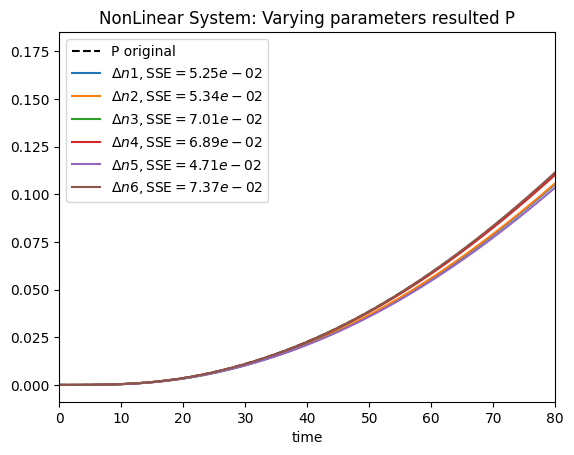

In [47]:
# simulated variation in nonlinear ode system
reset_parameters(values)
sol_0 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 1, 1, 1, 1, 1))
sol_1 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 0.9, 1, 1, 1, 1, 1))
sol_2 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 0.9, 1, 1, 1, 1))
sol_3 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 1, 0.9, 1, 1, 1))
sol_4 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 1, 1, 0.9, 1, 1))
sol_5 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 1, 1, 1, 0.9, 1))
sol_6 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta, 1, 1, 1, 1, 1, 0.9))

# Compute SSE (Sum of Squared Errors) for each case. Notice the less the SSE the less the perturbation due to varying parameters. So we are looking for the max deviation.
SSEs = []
for i, sol_case in enumerate([sol_1, sol_2, sol_3, sol_4, sol_5, sol_6], start=1):
    sse = np.sum((sol.y[5, :] - sol_case.y[5, :]) ** 2)
    print(f"Case {i}: SSE = {sse}")
    SSEs.append(sse)
    
max_SSE_value = max(SSEs)
max_SSE_case = SSEs.index(max_SSE_value) + 1  # Adding 1 to match the 1-based indexing in the print output

print(f"Max SSE occurs at case {max_SSE_case}, with value: {max_SSE_value}")
#plt.scatter(x_dat,y_dat,color='black')
plt.plot(sol.t, sol_0.y[5,:], label='P original', linestyle='--', color='black')
plt.plot(sol.t, sol_1.y[5, :], label=fr'$\Delta n1, \mathrm{{SSE}} = {SSEs[0]:.2e}$')
plt.plot(sol.t, sol_2.y[5, :], label=fr'$\Delta n2, \mathrm{{SSE}} = {SSEs[1]:.2e}$')
plt.plot(sol.t, sol_3.y[5, :], label=fr'$\Delta n3, \mathrm{{SSE}} = {SSEs[2]:.2e}$')
plt.plot(sol.t, sol_4.y[5, :], label=fr'$\Delta n4, \mathrm{{SSE}} = {SSEs[3]:.2e}$')
plt.plot(sol.t, sol_5.y[5, :], label=fr'$\Delta n5, \mathrm{{SSE}} = {SSEs[4]:.2e}$')
plt.plot(sol.t, sol_6.y[5, :], label=fr'$\Delta n6, \mathrm{{SSE}} = {SSEs[5]:.2e}$')
plt.xlim(0,80)
plt.xlabel('time')
plt.legend(loc='upper left')
plt.title("NonLinear System: Varying parameters resulted P")
#plt.savefig('figures/NonLinearSensitivity.png')
plt.show()



sensitivities matrix S =
 [[0.0000e+00 0.0000e+00 1.9940e-06 0.0000e+00 0.0000e+00 1.9940e-11]
 [0.0000e+00 0.0000e+00 9.9900e-04 0.0000e+00 0.0000e+00 9.9901e-09]
 [0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e-05]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]
Max Value: 1.0
Max Position: (2, 2)
elasticities matrix E =
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Max Value: (1+0j)
Max Position: (2, 2)


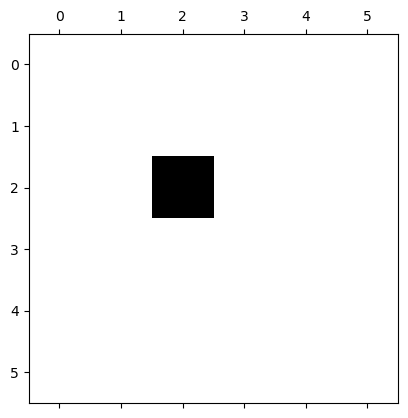

In [ ]:
# Define the symbols used in the matrix
R12, R14, R23, R25, R36, R45, R56 = symbols('R12 R14 R23 R25 R36 R45 R56')
K_A, K_R, gamma3, gamma4, gamma5, delta = symbols('K_A K_R gamma_3 gamma_4 gamma_5 delta')
n3, n4, n5, P = symbols('n3 n4 n5 P')

# Define A, B, and C as per the provided equations
A = -R36 + gamma3 - (2 * gamma3 * n3) / K_A - (gamma3 * n4) / K_A - (gamma3 * n5) / K_A - delta
B = -R45 + gamma4 - (gamma4 * n3) / K_R - (2 * gamma4 * n4) / K_R - (gamma4 * n5) / K_R - delta
C = -R56 + gamma5 - (gamma5 * n3) / K_R - (gamma5 * n4) / K_R - (2 * gamma5 * n5) / K_R - delta

# Define the matrix J
J = Matrix([
    [-R12 - R14, 0, 0, 0, 0, 0],
    [R12, -R23 - R25, 0, 0, 0, 0],
    [0, R23, A, -gamma3 * n3 / K_A, -gamma3 * n3 / K_A, 0],
    [R14, 0, -gamma4 * n4 / K_R, B, -gamma4 * n4 / K_R, 0],
    [0, R25, -gamma5 * n5 / K_R, R45 - gamma5 * n5 / K_R, C, 0],
    [0, 0, R36 - R36 * P, 0, R56 - R56 * P, -R56 * n5 - R36 * n3]
])

# Display the original matrix J
# print("Matrix J:", J)

# Substitute n3, n4, n5, and P = 0 into the matrix (1st equilibrium points)
J_equilibrium = J.subs({n3: 0, n4: 0, n5: 0, P: 0})

# Display the evaluated matrix
# print("Evaluated Matrix J:", J_equilibrium)

J_result = np.array(J_equilibrium.subs(values).tolist(), dtype=float)

# compute sensitivity and elasticity matrix
l_right, v_right = sortEig(J_result)
v_right_max = v_right[:,-1]

l_left, v_left = sortEig(np.transpose(J_result))
v_left_max = v_left[:,-1]

np.set_printoptions(precision=4)
S = np.outer(v_left_max,v_right_max) / np.dot(v_left_max,v_right_max)
print("sensitivities matrix S =\n", np.real(S))

max_value_S = np.max(S)
max_position_S = np.unravel_index(np.argmax(S), S.shape)

print("Max Value:", max_value_S)
print("Max Position:", max_position_S)

E = S * J_result / l_left[-1]
print("elasticities matrix E =\n", np.real(E))

max_value_E = np.max(E)
max_position_E = np.unravel_index(np.argmax(E), E.shape)

print("Max Value:", max_value_E)
print("Max Position:", max_position_E)
plt.spy(np.real(E))